# High-Frequency Effects and Modelling on FX Market in Response to US Macroeconomic Data Releases

## Steps:
1. Research and Planning
    * Define clear research goals and objectives
    * Decide on macroeconomic events and FX pairs
2. Literature Review
    * Review past papers
    * Identify gaps
3. Data Collection and Processing
    * Identify data sources
    * Collect FX pairs (date, minute interval, 
    * Collect macroeconomic events (date, expected value, actual value)
    * Merge datasets
    * Do some analysis for data dimensionality (e.g., analysis whether to keep 10 minutes before and 10 minutes after only of the data release)
    * Keep only data with the macro events (not whole month but only on data releases)
4. Exploratory Analysis
    * Correlation of price movement with each macro event expected vs actual
    * Feature importance (which macro event brings more volume)
5. Model Development
    * Create some either ABM or probabilistic TS model based on historical data
6. Backtesting and Market Simulation
    * KPIs and statistical measurement of model on test data (can be same as past)
    * Create a class/function to take input of a pair, expected value of macro data, and minute after event to give some price range and classification with confidence interval
* Results and Discusion
    * Interpret market reactions to economic data
    * Compare model accuracy with benchmarks

## Libraries

In [1]:
# Import of libraries
import yfinance as yf
from polygon import RESTClient

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

## Data
* Data Collection FX pair tickers (symbols) for **Yahoo Finance**: 
    * **DXY** 🠆 "DX-Y.NYB",
    * **USD/GBP** 🠆 "GBPUSD=X",
    * **USD/EUR** 🠆 "EURUSD=X",
    * **USD/CNY** 🠆 "CNY=X"


* Data Collection FX pair tickers (symbols) for **Polygon.io**:
    * **USD/EUR** 🠆 C:USD/EUR
    * **USD/GBP** 🠆 C:USD/GBP
    * **USD/CNY** 🠆 C:USD/CHF

In [2]:
def yf_get_fx_data(fx_pair, interval, start_date, end_date):
    """
    Retrieve historical data for a given FX pair from Yahoo Finance. 

    Parameters:
    - fx_pair (str): The FX pair to retrieve data for FX pairs and DXY (USD Index).
    - interval (str): The interval for the data (e.g., '1m', '1d', '1wk', '1mo').
    - start_date (str): The start date in 'YYYY-MM-DD' format.
    - end_date (str): The end date in 'YYYY-MM-DD' format.

    Returns:
    - pd.DataFrame: A DataFrame containing the historical data.
    """
    try:
        # Fetch data using yfinance in the form of 'Year-Month-Date Minutes'
        data = yf.download(fx_pair, start=start_date, end=end_date, interval=interval)
        
        # Modify datetime and set it as index
        data.index = data.index.strftime('%Y-%m-%d %H:%M')
        
        # Column manipulation
        data.columns = data.columns.droplevel(1) # Drop the Ticker Column level
        data = data.rename_axis(f'{fx_pair}', axis=1) # Rename axis 1
        data.index = pd.to_datetime(data.index)
        data = data[["Open", "High", "Low", "Adj Close"]]

        return data
    
    except Exception as e:
        print(f"An error occurred: {e}")
        return None


def polygon_get_fx_data(fx_pair, interval, start_date, end_date, api_key='0GbCWQKVtPfEMJvPmc1n50psE3zsW1c8'):
    """
    Retrieve historical FX data from Polygon.io.

    Parameters:
    - interval (str): The interval for the data ('1m', '5m', '1h', '1d').
    - start_date (str): The start date in 'YYYY-MM-DD' format.
    - end_date (str): The end date in 'YYYY-MM-DD' format.
    - api_key (str): Polygon.io API key.

    Returns:
    - pd.DataFrame: A DataFrame containing historical USD/CNY forex data.
    """
    try:
        # Bring the fx pair ticker to Polygon's format
        fx_pair_polygon_formated = "C:" + str(fx_pair)

        client = RESTClient(api_key)

        # Request data
        data_request = client.get_aggs(
            ticker=fx_pair_polygon_formated, 
            multiplier=1, 
            timespan=interval,
            from_=start_date, 
            to=end_date
        )
    
        # Convert response to DataFrame
        df = pd.DataFrame(data_request)
        
        # Check if data is returned
        if df.empty:
            print("No data found.")
            return None

        # Convert timestamp to datetime format and set Datetime as an index
        df["Datetime"] = pd.to_datetime(df["timestamp"], unit="ms")
        df.set_index("Datetime", inplace=True)
        
        # Drop columns not needed
        df = df.drop(columns=["otc", "transactions", "timestamp"])
        
        # Rename columns to align with yf for the feature engineering and merging later on
        df = df.rename(columns={"open": "Open", "high": "High", "low": "Low", "close": "Adj Close", "volume": "Volume"})
        df = df.rename_axis(f'{fx_pair}', axis=1)
        
        return df

    except Exception as e:
        print(f"An error occurred: {e}")
        return None

In [16]:
def calculate_volatility(df):
    """
    Calculate the average volatility dynamically based on the number of rows in the DataFrame.

    Parameters:
    - df (pd.DataFrame): FX data.

    Returns:
    - pd.DataFrame: The original DataFrame with added 'Volatility', 'Average_Volatility', and 'Volatility_Multiplier' columns.

    """

    if df is None or df.empty:
        print("Error: DataFrame is empty or invalid.")
        return None

    # Calculate Log Returns
    df['Log_Returns'] = np.log(df['Adj Close'] / df['Adj Close'].shift(1))
    # Compute Volatility
    df['Volatility'] = df['Log_Returns'].abs()
    # Compute Average Volatility based on number of rows
    df['Average_Volatility'] = df['Volatility'].mean()
    # Compute Volatility Multiplier
    df['Volatility_Multiplier'] = round(df['Volatility'] / df['Average_Volatility'],2)

    return df


def plot_time_series(df, column):
    """
    Plots a time series for a given data and column.

    Parameters:
    - df (pd.DataFrame): DataFrame containing time series data with a Datetime index.
    - column (str): Column name to plot.
    - title (str): Title of the plot (default: "Time Series Plot").

    Returns:
    - None (Displays the plot)
    """
    
    if column not in df.columns:
        print(f"Error: Column '{column}' not found in DataFrame.")
        return None
    
    fx_pair = df.columns.name if df.columns.name else "FX Pair"
    # Create plot
    fig, ax = plt.subplots(figsize=(12, 6))
    df[column].plot(ax=ax)
    
    # Improve x-axis readability
    ax.set_xlabel("Datetime", fontsize=12)
    ax.set_ylabel(column, fontsize=12)
    ax.set_title(f"'{fx_pair}' {column} Over Time", fontsize=14)
    ax.tick_params(axis='x', rotation=0)
    
    # Ensure the x-axis starts and ends exactly at the first and last data points (applicable only to yf data)
    if "vwap" not in df.columns:
        # Format x-axis to time
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
        ax.set_xlim(df.index.min(), df.index.max())

    ax.grid(True, which="major", linestyle="-", linewidth=0.6, alpha=1)  # Major grid
    ax.grid(True, which="minor", linestyle="-", linewidth=0.5, alpha=1)  # Minor grid

    plt.show()
    pass

In [22]:
fx_data = calculate_volatility(yf_get_fx_data('USDGBP=X', '1m', '2025-01-15', '2025-01-16'))
# fx_data

[*********************100%***********************]  1 of 1 completed


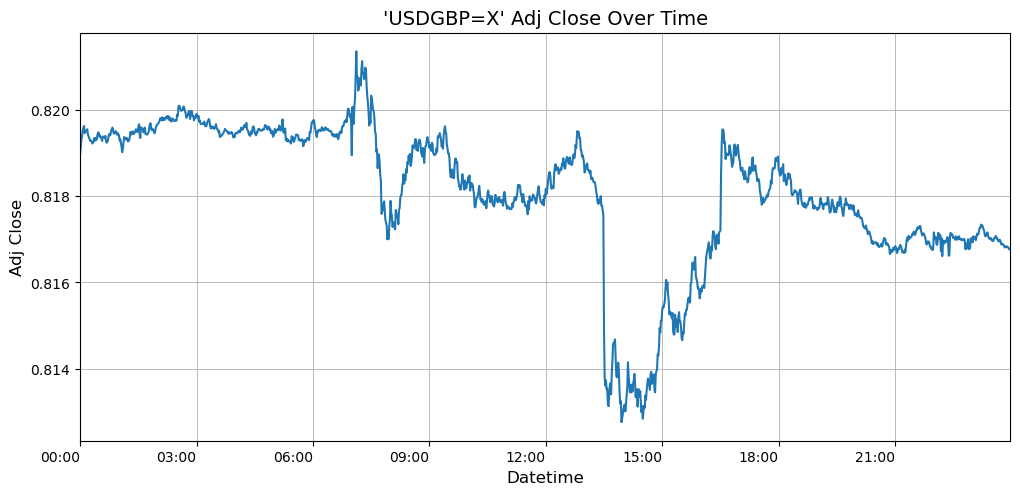

In [23]:
plot_time_series(fx_data, column="Adj Close")

In [24]:
polygon_fx_data = calculate_volatility(polygon_get_fx_data("USDGBP", "minute", "2025-01-15", "2025-01-15"))
# polygon_fx_data

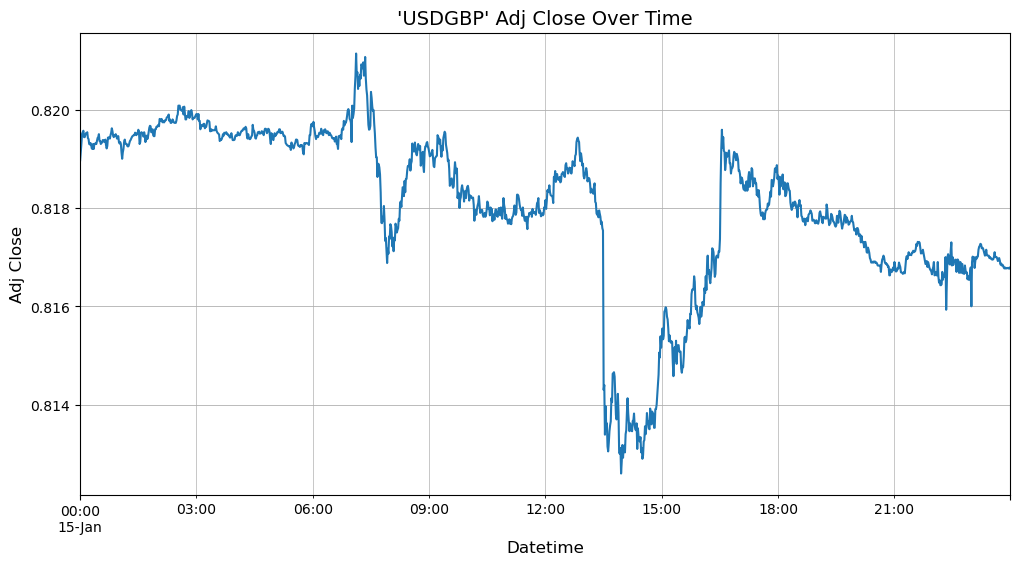

In [25]:
polygon_fx_data.index = pd.to_datetime(polygon_fx_data.index)
plot_time_series(polygon_fx_data, "Adj Close")